Example with two concentric circles, and a bit of noise.

In [13]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

import clustergraph.clustergraph as cg
from clustergraph.utils import get_clusters_from_scikit
from clustergraph.plot_graph import draw_graph

## Read data

(500, 2)


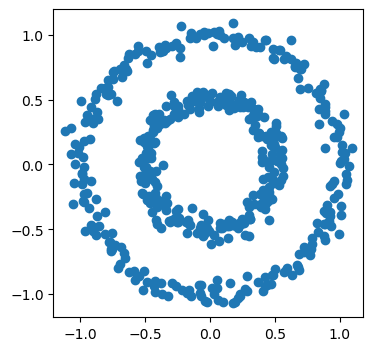

In [14]:
data = pd.read_csv("data/noisy_circles.csv", sep=",", header=None)
X = data.to_numpy()
print(X.shape)

plt.figure(figsize=(4, 4))
plt.scatter(data[0], data[1])
plt.axis("equal")
plt.show()

## Clustering

We cluster the datapoints using Kmeans and plot the output on top of the 10-nearest neighbours graph.

In [15]:
model_KM = KMeans(20, random_state=42)
prediction_KM = model_KM.fit_predict(X)

# model_DB = DBSCAN(eps=0.2, min_samples=5)
# predict_DB = model_DB.fit_predict(X)
# X1 = X[predict_DB == 0]
# X2 = X[predict_DB == 1]
# colors = []

# # Get one cluster per circle in order to have the corresponding labels
# for i in range(len(predict_DB)):
#     if predict_DB[i] == 0:
#         colors.append("#3182bd")
#     else:
#         colors.append("#a1d99b")

# labels_circles = np.array(colors)
# print(np.unique(predict_DB))

Number connected components :  2


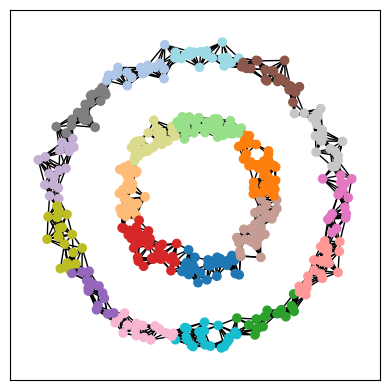

In [16]:
nb = 10
neigh = NearestNeighbors(n_neighbors=nb, radius=1)
neigh.fit(X=X)
nn_adjacency = neigh.kneighbors_graph(X=X, n_neighbors=nb, mode="distance")
nn_Graph = nx.from_scipy_sparse_array(nn_adjacency, edge_attribute="weight")

for node in nn_Graph.nodes:
    nn_Graph.remove_edge(node, node)
print("Number connected components : ", nx.number_connected_components(nn_Graph))

fig, ax = plt.subplots(figsize=(4, 4))
nx.draw_networkx_edges(
    nn_Graph,
    pos={i: p for i, p in enumerate(X)},
    ax=ax,
)
ax.scatter(X[:, 0], X[:, 1], c=prediction_KM, cmap="tab20")
ax.axis("equal")

plt.tight_layout()
# plt.savefig("circles_kmeans.pdf")
plt.show()

### ClusterGraph's creation and pruning

In [17]:
cluster_g = cg.ClusterGraph(
    clusters=get_clusters_from_scikit(prediction_KM), X=X, metric_clusters="average"
)
# Coloring the graph
cluster_g.fit_graph(
    node_type_coloring="label",
    node_color_labels=prediction_KM,
    node_palette=cm.get_cmap("tab20"),
)

# Distortion pruning
metric_distortion_graph, md = cluster_g.prune_distortion(knn_g=10, score=True)

# Connectivity pruning
connectivity_graph, conn = cluster_g.prune_conn(score=True)

### Plot of the metric distortion and connectivity

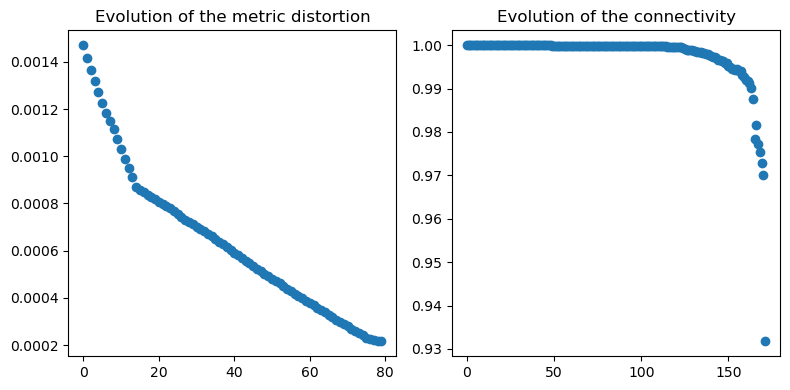

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.scatter(range(len(md)), md)
ax1.set_title("Evolution of the metric distortion")

ax2.scatter(range(len(conn)), conn)
ax2.set_title("Evolution of the connectivity")

plt.tight_layout()
plt.show()

# Graph after the metric distortion pruning

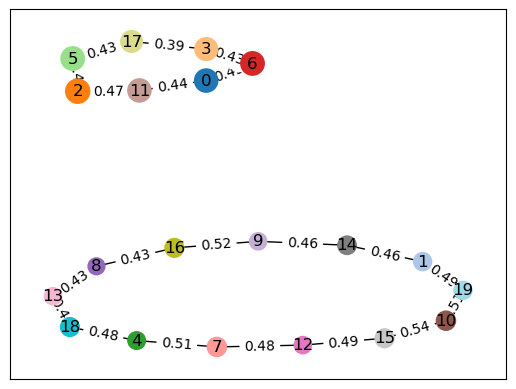

In [19]:
metric_distortion_graph = cluster_g.prune_distortion()
draw_graph(metric_distortion_graph, size_nodes=1000, random_state=42)

### Merge of disconnected components

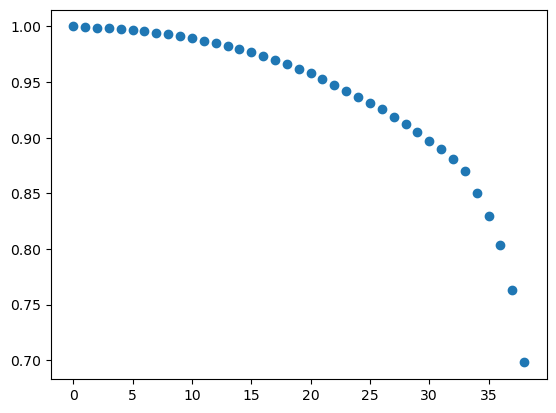

In [20]:
merged_graph, connectivity = cluster_g.merge_graph(k_compo=3, score=True)
plt.scatter(range(len(connectivity)), connectivity)

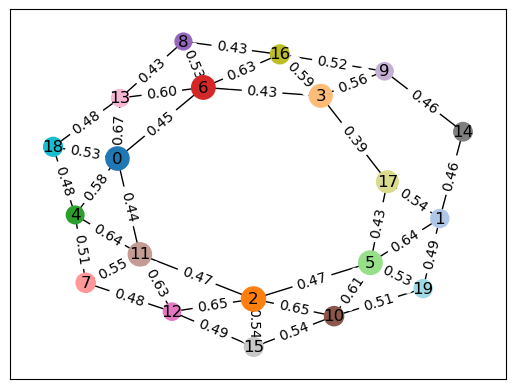

In [21]:
merged_graph = cluster_g.merge_graph(20, k_compo=3)
draw_graph(merged_graph, size_nodes=1000, random_state=42)

## Connectivity Pruning : Graph with 0.99% of the connectivity kept

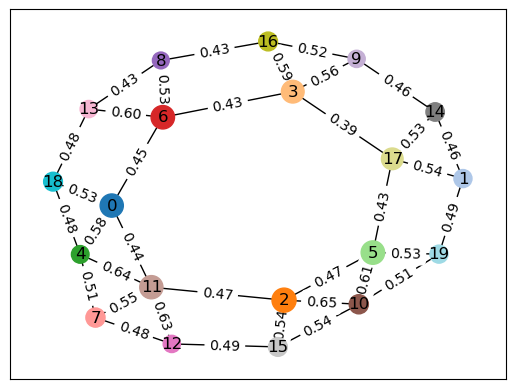

In [22]:
connectivity_graph = cluster_g.prune_conn(nb_edge_pruned=155)
draw_graph(connectivity_graph, size_nodes=1000, random_state=42)